In [19]:
%pylab inline
import json
import os
import cosmology
import numpy as np
import astropy.io.fits as pyfits
import ipyvolume as ipv
import ipyvolume.pylab as pvlt

try:
    # use lsst.afw.display and firefly backend for display
    import lsst.log as logging
    import lsst.afw.image as afwImage
    haslsst=True
except ImportError:
    haslsst=False
from configparser import ConfigParser

def zMeanBin(zMin,dz,nz):
    return np.arange(zMin,zMin+dz*nz,dz)+dz/2.

# LASSO Threshold Functions
def soft_thresholding(dum,thresholds):
    # Standard Threshold Function
    return np.sign(dum)*np.maximum(np.abs(dum)-thresholds,0.)

def firm_thresholding(dum,thresholds):
    # Glimpse13 uses f
    mask    =   (np.abs(dum)<= thresholds)
    dum[mask]=  0.
    mask    =   (np.abs(dum)>thresholds)
    mask    =   mask&(np.abs(dum)<= 2*thresholds)
    dum[mask]=  np.sign(dum[mask])*(2*np.abs(dum[mask])-thresholds[mask])
    return dum

def my_thresholding(dum,thresholds):
    # doesnot work @_@
    mask    =   (abs(dum)<= thresholds)
    dum[mask]=  0.
    mask    =   (abs(dum)>thresholds)
    dum[mask]=  np.sign(dum[mask])*(abs(dum[mask])-thresholds[mask]**2./abs(dum[mask]))
    return dum

class massmap_ks2D():
    def __init__(self,ny,nx):
        self.shape   =   (ny,nx)
        self.e2phiF  =   self.e2phiFou(self.shape)

    def e2phiFou(self,shape):
        ny1,nx1 =   shape
        e2phiF  =   np.zeros(shape,dtype=complex)
        for j in range(ny1):
            jy  =   (j+ny1//2)%ny1-ny1//2
            jy  =   jy/ny1
            for i in range(nx1):
                ix  =   (i+nx1//2)%nx1-nx1//2
                ix  =   ix/nx1
                if (i**2+j**2)>0:
                    e2phiF[j,i]    =   np.complex((ix**2.-jy**2.),2.*ix*jy)/(ix**2.+jy**2.)
                else:
                    e2phiF[j,i]    =   1.
        return e2phiF*np.pi

    def itransform(self,gMap,inFou=True,outFou=True):
        assert gMap.shape==self.shape
        if not inFou:
            gMap =   np.fft.fft2(gMap)
        kOMap    =   gMap/self.e2phiF*np.pi
        if not outFou:
            kOMap    =   np.fft.ifft2(kOMap)
        return kOMap

    def transform(self,kMap,inFou=True,outFou=True):
        assert kMap.shape==self.shape
        if not inFou:
            kMap =   np.fft.fft2(kMap)
        gOMap    =   kMap*self.e2phiF/np.pi
        if not outFou:
            gOMap    =   np.fft.ifft2(gOMap)
        return gOMap

class massmapSparsityTask():
    def __init__(self,parser):
        #display
        self.display_iframe=0
        if parser.has_option('file','fieldN'):
            self.fieldN =   parser.get('file','fieldN')
        else:
            self.fieldN  =   'test'
        if parser.has_option('file','outDir'):
            self.outDir =   parser.get('file','outDir')
        else:
            self.outDir  =   './'
        self.debugRange=[]#range(1,100,10)

        #sparse
        self.aprox_method    =   parser.get('sparse','aprox_method')
        self.lbd    =   parser.getfloat('sparse','lbd') #Sparsity
        if parser.has_option('sparse','lbd2'):          #Total Square Variance
            self.lbd2   =   parser.getfloat('sparse','lbd2')
        else:
            self.lbd2   =   0.
        self.nframe =   parser.getint('sparse','nframe')
        outFname    =   'deltaMap_lbd%.1f_%s.fits' %(self.lbd,self.fieldN)
        self.outFname   =   os.path.join(self.outDir,outFname)

        #pixelization
        
        ##transverse plane
        self.ny     =   parser.getint('transPlane','ny')
        self.nx     =   parser.getint('transPlane','nx')
        ##lens z axis
        self.nlp    =   parser.getint('lensZ','nlp')
        
        if self.nlp<=1:
            self.zlMin  =   0.
            self.zlscale=   1.
        else:
            self.zlMin       =   parser.getfloat('lensZ','zlMin')
            self.zlscale     =   parser.getfloat('lensZ','zlscale')
        self.zlBin       =   zMeanBin(self.zlMin,self.zlscale,self.nlp)

        ##source z axis
        self.nz     =   parser.getint('sourceZ','nz')
        if self.nz<=1:
            self.zMin   =   0.05
            self.zscale =   2.5
            self.zsBin      =   zMeanBin(self.zMin,self.zscale,self.nz)
        else:
            zbound =   np.array(json.loads(parser.get('sourceZ','zbound')))
            self.zsBin =   (zbound[:-1]+zbound[1:])/2.

        self.shapeS =   (self.nz,self.ny,self.nx)
        self.shapeL =   (self.nlp,self.ny,self.nx)
        self.shapeA =   (self.nlp,self.nframe,self.ny,self.nx)

        self.cosmo  =   cosmology.Cosmo(h=1)
        self.lensing_kernel(self.zlBin,self.zsBin)

        dicname =   parser.get('sparse','dicname')
        if dicname=='starlet':
            from halolet import starlet2D
            self.dict2D =   starlet2D(gen=2,nframe=self.nframe,ny=self.ny,nx=self.nx)
        elif dicname=='nfwlet':
            from halolet import nfwlet2D
            self.dict2D =   nfwlet2D(nframe=self.nframe,ngrid=self.nx,smooth_scale=-1)
        self.ks2D   =   massmap_ks2D(self.ny,self.nx)

        # Read pixelized shear and mask
        sigfname    =   parser.get('prepare','sigmafname')
        g1fname     =   parser.get('prepare','g1fname')
        g2fname     =   parser.get('prepare','g2fname')
        self.sigmaS =   pyfits.getdata(sigfname)
        g1Map=pyfits.getdata(g1fname)[0]
        g2Map=pyfits.getdata(g2fname)[0]
        assert g1Map.shape  ==   self.shapeS, \
            'load wrong pixelized shear, shape map shape: (%d,%d,%d)' %g1Map.shape
        assert self.sigmaS.shape  ==   self.shapeS, \
            'load wrong pixelized std, shape map shape: (%d,%d,%d)' %self.sigmaS.shape
        self.mask   =   (self.sigmaS>=1.e-4)

        # Estimate Spectrum
        self.spectrum_norm()

        # Estimate variance plane for alpha
        sigma_noise =   parser.getfloat('sparse','sigma_noise')
        self.prox_sigmaA(100)
        sigmaName   =   os.path.join(self.outDir,'sigmaA_%s.fits' %self.fieldN)
        pyfits.writeto(sigmaName,self.sigmaA[:,self.display_iframe],overwrite=True)
        muName   =   os.path.join(self.outDir,'mu_%s.fits' %self.fieldN)
        pyfits.writeto(muName,self.mu[:,self.display_iframe],overwrite=True)
        
        # Initialization
        self.alphaR =   np.zeros(self.shapeA)   # alpha
        self.deltaR =   np.zeros(self.shapeL)   # delta
        self.shearRRes   = np.zeros(self.shapeS)# shear residuals
        self.shearR =   g1Map+np.complex128(1j)*g2Map # shear
        return

    def lensing_kernel(self,zlbin,zsbin):
        logging.info('Calculating lensing kernel')
        if self.nlp<=1:
            self.lensKernel =   np.ones((self.nz,self.nlp))
        else:
            self.lensKernel =   np.zeros((self.nz,self.nlp))
            for i,zs in enumerate(zsbin):
                self.lensKernel[i,:]    =   self.cosmo.deltacritinv(zlbin,zs)
        return

    def main_forward(self,alphaRIn):
        shearOut    =   np.zeros(self.shapeS,dtype=np.complex128)
        for zl in range(self.nlp):
            deltaFZl=   self.dict2D.itransform(alphaRIn[zl,:,:,:],inFou=False)
            shearRZl=   self.ks2D.transform(deltaFZl,outFou=False)
            shearOut+=  (self.lensKernel[:,zl,None,None]*shearRZl)
        shearOut    =   shearOut*(self.mask.astype(np.int))
        return shearOut

    def main_transpose(self,shearRIn):
        deltaFTmp       =   np.zeros(self.shapeL,dtype=np.complex128)
        for zs in range(self.nz):
            kappaFZs    =   self.ks2D.itransform(shearRIn[zs],inFou=False)
            deltaFTmp  +=   (self.lensKernel[zs,:,None,None]*kappaFZs)
        alphaRO         =   np.empty(self.shapeA)
        for zl in range(self.nlp):
            alphaRO[zl,:,:,:]=self.dict2D.itranspose(deltaFTmp[zl],outFou=False).real
        return alphaRO

    def gradient_chi2(self):
        # sparseBase.massmapSparsityTask.gradient_chi2
        # calculate the gradient of the chi2 component
        shearRTmp   =   self.main_forward(self.alphaR) #A_{ij} x_j
        self.shearRRes   =   self.shearR-shearRTmp     #y_i-A_{ij} x_j
        dalphaR     =   -self.main_transpose(self.shearRRes)/2. #-A_{i\alpha}(y-A_{ij} x_j)/2
        return dalphaR

    def gradient_TSV(self):
        # sparseBase.massmapSparsityTask.gradient_TSV
        # calculate the gradient of the Total Square Variance(TSV) component
        
        # Initialization
        dalphaR =   np.zeros(self.shapeA)
        
        difx    =   np.roll(self.alphaR[:,0,:,:],1,axis=-1)
        difx    =   difx-self.alphaR[:,0,:,:] #D1
        gradx   =   np.roll(difx,-1,axis=-1)
        gradx   =   gradx-difx # (D1)_{i\alpha} (D1)_{ij} x_j

        dify    =   np.roll(self.alphaR[:,0,:,:],1,axis=-2)
        dify    =   dify-self.alphaR[:,0,:,:] #D2
        grady   =   np.roll(dify,-1,axis=-2)
        grady   =   grady-dify # (D2)_{i\alpha} (D2)_{ij} x_j
        dalphaR[:,0,:,:]=(gradx+grady)*self.lbd2/2.
        return dalphaR

    def gradient(self):
        # sparseBase.massmapSparsityTask.gradient
        # calculate the gradient of the Second order component in loss function 
        # wihch includes Total Square Variance(TSV) and chi2 components
        gCh2=self.gradient_chi2()
        gTSV=self.gradient_TSV()
        return gCh2+gTSV

    def spectrum_norm(self):
        # sparseBase.massmapSparsityTask.spectrum_norm
        # Estimate A_{i\alpha} A_{i\alpha}
        asquareframe=np.zeros((self.nz,self.nframe,self.ny,self.nx))
        for iz in range(self.nz):
            maskF=np.fft.fft2(self.mask[iz,:,:])
            for iframe in range(self.nframe):
                fun=np.abs(self.ks2D.transform(self.dict2D.fouaframes[iframe,:,:],outFou=False))**2.
                asquareframe[iz,iframe,:,:]=np.fft.ifft2(np.fft.fft2(fun).real*maskF).real

        spectrum=np.sum(self.lensKernel[:,:,None,None,None]**2.*asquareframe[:,None,:,:,:],axis=0)
        
        # the first frame
        spectrum[:,0,:,:]=spectrum[:,0,:,:]+4.*self.lbd2 
        self.mu=1./spectrum
        return

    def prox_sigmaA(self,niter):
        logging.info('Estimating sigma map')
        outData     =   np.zeros(self.shapeA)
        for irun in range(niter):
            np.random.seed(irun)
            g1Sim   =   np.random.randn(self.nz,self.ny,self.nx)*self.sigmaS
            g2Sim   =   np.random.randn(self.nz,self.ny,self.nx)*self.sigmaS
            shearSim=   g1Sim+np.complex128(1j)*g2Sim
            alphaRSim=  -self.main_transpose(shearSim)/2.
            outData +=  alphaRSim**2.
                
        # 
        maskL =   np.all(self.sigmaS>1.e-4,axis=0)
        for izlp in range(self.nlp):
            for iframe in range(self.nframe):
                outData[izlp,iframe][~maskL]=np.max(outData[izlp,iframe])
        self.sigmaA =   self.mu*np.sqrt(outData/niter)
        return

    def reconstruct(self):
        #update deltaR
        for zl in range(self.nlp):
            alphaRZ         =   self.alphaR[zl].copy()
            self.deltaR[zl] =   self.dict2D.itransform(alphaRZ,inFou=False,outFou=False)/self.zlscale
        return

    def pathwise_coordinate_descent(self,iup,niter,threM='ST'):
        self.lbd_path=np.ones(niter)*100
        for irun in range(1,niter):
            self.dalphaR =   -self.mu*self.gradient().real
            # Update thresholds
            snrArray=np.abs(self.dalphaR)/self.sigmaA
            ind=np.unravel_index(np.argmax(snrArray, axis=None), snrArray.shape)
            if snrArray[ind]<self.lbd:
                self.lbd_path[irun:]=self.lbd
                return
            elif snrArray[ind]>1.02*self.lbd_path[irun-1]:
                # do not update threshold if the maximum is larger than lbd
                # record it to lbd_path
                self.lbd_path[irun]=self.lbd_path[irun-1]
            else:
                # decrease threshold
                self.lbd_path[irun]=max(snrArray[ind]*0.98,self.lbd)
                self.thresholds=self.lbd_path[irun]*self.sigmaA
            dum     =   self.alphaR+self.dalphaR
            if threM=='ST':
                self.alphaR[ind]  = soft_thresholding(dum,self.thresholds)[ind]
            elif threM=='FT':
                self.alphaR[ind]  = firm_thresholding(dum,self.thresholds)[ind]
            # Write (Display) the fits file
            if irun in self.debugRange:
                self.reconstruct()
                ratioPlot=self.dalphaR[:,self.display_iframe]/self.sigmaA[:,self.display_iframe]
                for il in range(self.nlp):
                    print('max snr in %d lens bin is %.3f' %(il,ratioPlot[il].max()))
                ratioPlot[ratioPlot<self.lbd]=0.
                pyfits.writeto('deltaR_%s_%d_%d.fits' %(self.fieldN,iup,irun),self.deltaR.real,overwrite=True)
                pyfits.writeto('alphaR_%s_%d_%d.fits' %(self.fieldN,iup,irun),self.alphaR.real[:,self.display_iframe],overwrite=True)
                pyfits.writeto('dalphaR_over_sigma_%s_%d_%d.fits' %(self.fieldN,iup,irun),ratioPlot,overwrite=True)
        return
    
    def fista_gradient_descent(self,iup,niter,threM='ST'):
        covInv=0.05 # TODO: Estimate covInv numerically?
        self.sigmaA=self.sigmaA*covInv
        self.mu=self.mu*covInv
        self.thresholds =   self.lbd*self.sigmaA
        tn=0
        for irun in range(niter):
            #save old kappaFou
            self.dalphaR =   -self.mu*self.gradient().real
            dum     =   self.alphaR+self.dalphaR
            if threM=='ST':
                dum  = soft_thresholding(dum,self.thresholds)
            elif threM=='FT':
                dum  = firm_thresholding(dum,self.thresholds)
            #update x_\alpha according to FISTA
            tnTmp= (1.+np.sqrt(1.+4*tn**2.))/2.
            ratio= (tn-1.)/tnTmp
            tn   = tnTmp
            self.alphaR=dum+(ratio*(dum-self.alphaR))
            # Write (Display) the fits file
            if irun in self.debugRange:
                self.reconstruct()
                ratioPlot=self.dalphaR[:,self.display_iframe]/self.sigmaA[:,self.display_iframe]
                for il in range(self.nlp):
                    print('max snr in %d lens bin is %.3f' %(il,ratioPlot[il].max()))
                ratioPlot[ratioPlot<self.lbd]=0.
                pyfits.writeto('deltaR_%s_%d_%d.fits' %(self.fieldN,iup,irun),self.deltaR.real,overwrite=True)
                pyfits.writeto('alphaR_%s_%d_%d.fits' %(self.fieldN,iup,irun),self.alphaR.real[:,self.display_iframe],overwrite=True)
                pyfits.writeto('dalphaR_over_sigma_%s_%d_%d.fits' %(self.fieldN,iup,irun),ratioPlot,overwrite=True)
        return

    def process(self,niter=1000):
        if self.aprox_method=='pathwise':
            self.pathwise_coordinate_descent(0,niter,'ST')
        elif self.aprox_method=='fista':
            self.fista_gradient_descent(0,niter,'ST')
        self.reconstruct()
        return

    def write(self):
        pyfits.writeto(self.outFname,self.deltaR.real,overwrite=True)
        return

Populating the interactive namespace from numpy and matplotlib


# LASSO

## Loss Function

$$L(\vec{x})=\frac{1}{2}(y_{i}-A^{*}_{ij}x_{j})(y_{i}-A_{ik}x_{k})+\frac{\lambda_2}{2}[(D^{1}_{ij} x_{j})(D^{1}_{ik}x_{k})+ (D^{2}_{ij} x_{j})(D^{2}_{ik}x_{k})]+ \lambda_1 \sigma_i |x_i|,$$

where $x_i$ is the i-th component of real vector $\vec{x}$, $A_{ij}$ and $D^{1,2}_{ij}$ are the $(i,j)$ component of matrix $\mathbf{A}$ and $\mathbf{D^{1,2}}$. $A_{ij}$ is complex number whereas $D^{1,2}_{ij}$ are real number. $A^{*}_{ij}$ is used to denote the conjugate of $A_{ij}$.

$\mathbf{A}$ refers to the transformation operator from the real dictionary field to the observed complex shear field. Note that we do not consider $B$ mode so $x$ is a real vector. 

```python
# sparseBase.massmapSparsityTask.__init__
## Initialization of the Dictionary Space (A)
# 1) Basis vector used to model the Surface Density of halo  
if dicname=='starlet':
    from halolet import starlet2D
    self.dict2D =   starlet2D(gen=2,nframe=self.nframe,ny=self.ny,nx=self.nx)
elif dicname=='nfwlet':
    from halolet import nfwlet2D
    self.dict2D =   nfwlet2D(nframe=self.nframe,ngrid=self.nx,smooth_scale=-1)
# 2) From Surface Density of Excess Surface Density
self.ks2D   =   massmap_ks2D(self.ny,self.nx)

# 3) Lening Kernel: from Excess Surface Density to Shear

if self.nlp<=1:
    self.lensKernel =   np.ones((self.nz,self.nlp))
else:
    self.lensKernel =   np.zeros((self.nz,self.nlp))
    for i,zs in enumerate(zsbin):
        self.lensKernel[i,:]    =   self.cosmo.deltacritinv(zlbin,zs)
```

$\mathbf{D^{1,2}}$ refer to difference operators in two transverse  (ra, dec) directions. $\lambda_2$ control the amplitude of the Total Square Variance (TSV) term.


```python
# sparseBase.massmapSparsityTask.gradient_TSV
# Definition of D1 and D2
difx    =   np.roll(self.alphaR[:,0,:,:],1,axis=-1)
difx    =   difx-self.alphaR[:,0,:,:] # D1
dify    =   np.roll(self.alphaR[:,0,:,:],1,axis=-2)
dify    =   dify-self.alphaR[:,0,:,:] # D2
```

## Second Order Term

We separate out the second order terms in the loss function.

$$F(\vec{x})=\frac{1}{2}(y_{i}-A^{*}_{ij}x_{j})(y_{i}-A_{ik}x_{k})+\frac{\lambda_2}{2}[(D^{1}_{ij} x_{j})(D^{1}_{ik}x_{k})+ (D^{2}_{ij} x_{j})(D^{2}_{ik}x_{k})].$$

The gradient of it is

$$\partial_\alpha F(\vec{x})=-A_{i\alpha}^{*} (y_{i}-A_{ij}x_{j}) + \lambda_2(D^1_{i\alpha}D^1_{ij} x_{j}+ D^2_{i\alpha} D^2_{ij} x_j).$$


```python

# sparseBase.massmapSparsityTask.gradient
# calculate the gradient of the Second order component in loss function 
# wihch includes Total Square Variance(TSV) and chi2 components
gCh2=self.gradient_chi2()
gTSV=self.gradient_TSV()

# sparseBase.massmapSparsityTask.gradient_chi2
# calculate the gradient of the chi2 component
shearRTmp   =   self.main_forward(self.alphaR) #A_{ij} x_j
self.shearRRes   =   self.shearR-shearRTmp     #y_i-A_{ij} x_j
dalphaR     =   -self.main_transpose(self.shearRRes)/2. #-A_{i\alpha}(y_i-A_{ij} x_j)/2

# sparseBase.massmapSparsityTask.gradient_TSV
gradx   =   np.roll(difx,-1,axis=-1)
gradx   =   gradx-difx    # (D1)_{i\alpha} (D1)_{ij} x_j
grady   =   np.roll(dify,-1,axis=-2)  
grady   =   grady-dify    # (D2)_{i\alpha} (D2)_{ij} x_j
dalphaR[:,0,:,:]=(gradx+grady)*self.lbd2/2.
```



## Pathwise Coordinate Descent

The starting point is set to $x_i^{(0)}=0$. We approach to the minimum of the loss function ($L(\vec{x})$) by iteratively updates $\vec{x}$. For each iteration, we find the coordinate on which the projection of derivative has the largest signal to noise ratio. This coordinate is recorded as $x_{\alpha}$ and the largest signal to noise ratio is recorded as $\rm{S/N}_{\alpha}$. 
We update $\lambda=\rm{max}(0.98 \rm{S/N}_{\alpha}, \lambda_1)$. Then we update along this specific coordinate $x_{\alpha}$.

$$x_{\alpha}^{(n+1)}=S_{\lambda\sigma_{\alpha}}(x_{\alpha}^{(n)}-\frac{\partial_{\alpha}F(\vec{x})}{A_{i\alpha}A_{i\alpha}+4\lambda_2}),$$

$S_{\lambda}$ is the soft thresholding function defined as:

$$S_{\lambda} (x_{\alpha})=\rm{sign}(x_{\alpha}) \rm{max}(|x_{\alpha}| - \lambda,0)$$

```python
self.dalphaR =   -self.mu*self.gradient().real
# Update thresholds
snrArray=np.abs(self.dalphaR)/self.sigmaA
ind=np.unravel_index(np.argmax(snrArray, axis=None), snrArray.shape)
if snrArray[ind]<self.lbd:
    self.lbd_path[irun:]=self.lbd
    return
elif snrArray[ind]>1.02*self.lbd_path[irun-1]:
    # do not update threshold if the maximum is larger than lbd
    # record it to lbd_path
    self.lbd_path[irun]=self.lbd_path[irun-1]
else:
    # decrease threshold
    self.lbd_path[irun]=max(snrArray[ind]*0.98,self.lbd)
    self.thresholds=self.lbd_path[irun]*self.sigmaA
dum     =   self.alphaR+self.dalphaR
if threM=='ST':
    self.alphaR[ind]  = soft_thresholding(dum,self.thresholds)[ind]
elif threM=='FT':
    self.alphaR[ind]  = firm_thresholding(dum,self.thresholds)[ind]
```

Note that here $A_{i\alpha} A_{i\alpha}$ should be estimated taking into account the mask of observed shear field.
```python
# sparseBase.massmapSparsityTask.spectrum_norm
# Estimate A_{i\alpha} A_{i\alpha}
asquareframe=np.zeros((self.nz,self.nframe,self.ny,self.nx))
for iz in range(self.nz):
    maskF=np.fft.fft2(self.mask[iz,:,:])
    for iframe in range(self.nframe):
        fun=np.abs(self.ks2D.transform(self.dict2D.fouaframes[iframe,:,:],outFou=False))**2.
        asquareframe[iz,iframe,:,:]=np.fft.ifft2(np.fft.fft2(fun).real*maskF).real

spectrum=np.sum(self.lensKernel[:,:,None,None,None]*asquareframe[:,None,:,:,:],axis=0)
self.mu=1./(spectrum+4.*self.lbd2)
```


## FISTA Gradient Descent

The starting point is set to $x_i^{(0)}=0$. We approach to the minimum of the loss function ($L(\vec{x})$) by iteratively updates $\vec{x}$. For each iteration, we update along the gradient of $F(\vec{x})$ and each coordinate ($x_j$) of $\vec{x}$ is updated as follows: 

$$x_{j}^{(n+1)}=S_{\lambda_1 \sigma_{j}}(x_{j}^{(n)}- \mu \partial_{j} F(\vec{x}) ),$$

$\mu$ is the step size of the iteration. $S_{\lambda}$ is the soft thresholding function 

$$t^{(0)}=0$$

$$t^{(n+1)}= \frac{1+\sqrt{1+4(t^{(n)})^2}}{2}$$

$$\vec{x}^{(n+1)}=\vec{x}^{(n+1)}+\frac{t^{(n)} -1}{t^{(n+1)}} (\vec{x}^{(n+1)}-\vec{x}^{(n)})$$


```python
dalphaR =   -self.mu*self.gradient().real
dum     =   self.alphaR.real+dalphaR
if threM=='FT':
    dum  = firm_thresholding(dum,self.thresholds)
elif threM=='ST':
    dum  = soft_thresholding(dum,self.thresholds)
#update x_\alpha according to FISTA
tnTmp= (1.+np.sqrt(1.+4*tn**2.))/2.
ratio= (tn-1.)/tnTmp
tn   = tnTmp
self.alphaR=dum+(ratio*(dum-self.alphaR))
```

Note that the step size $\mu$ should be less or equal to the reciprocal of the largest eigenvalue of the matrix $A_{ij}A_{jk}$.
We estimate $\mu$ by simulating large number of random vectors and apply operator $A_{ij}A_{jk}$ to these random vecotrs

```python
norm=0.
for irun in range(100):
    np.random.seed(irun)
    alphaTmp=   np.random.randn(self.nlp,self.nframe,self.ny,self.nx)
    normTmp =   np.sqrt(np.sum(alphaTmp**2.))
    alphaTmp=   alphaTmp/normTmp
    shearTmp=   self.main_forward(alphaTmp)
    alphaTmp2=  self.main_transpose(shearTmp)
    normTmp2=   np.sqrt(np.sum(alphaTmp2**2.))
    if normTmp2>norm:
        norm=normTmp2
self.mu    = 1./norm/1.1
```

In [3]:
cd ./wrkDir/stampSim/HSC-like/

/lustre2/work/xiangchong.li/massMapSim/stampSim/HSC-like


In [5]:
configName  =   'process-equalNum10/config.ini'
parser      =   ConfigParser()
parser.read(configName)

['process-equalNum10/config.ini']

# A simple Simulation

$M_{200}=4.41 \times 10^{14} M_{\odot}$

$z=0.38$

$\sigma_\gamma=0.25$

$40$ galaxies per arcmin

# Pixel frame only

In [ ]:
parser.set('sparse','nframe','1')
parser.set('sparse','aprox_method','pathwise')
figure=plt.figure(figsize=(20,15))
for jplot in range(3):
    lbd1=(jplot+1)*0.3
    parser.set('sparse','lbd','%s' %lbd1)
    for iplot in range(4):
        ax=figure.add_subplot(3,4,jplot*4+iplot+1)
        lbd2=iplot*0.8
        parser.set('sparse','lbd2','%s' %lbd2)
        sparse3D    =   massmapSparsityTask(sources,parser)
        sparse3D.process()
        title=r'$\lambda_1=%.1f$,$\lambda_2=%.1f$' %(lbd1,lbd2)
        ax.imshow(sparse3D.deltaR[0,:,:])
        ax.set_title(title)

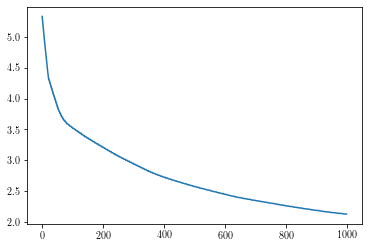

In [27]:
plt.plot(sparse3D.lbd_path[1:1000])

# Pixel frame + one halo frame 

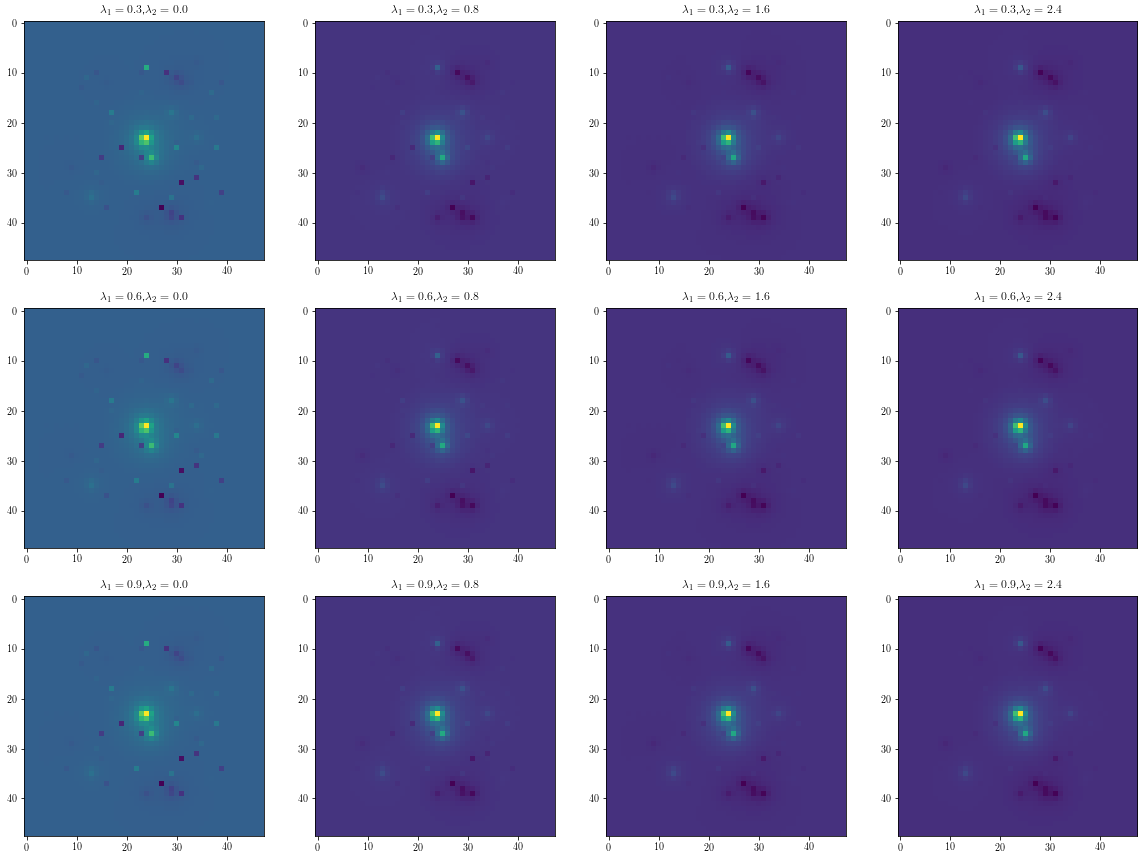

In [28]:
parser.set('sparse','nframe','2')
figure=plt.figure(figsize=(20,15))
for jplot in range(3):
    lbd1=(jplot+1)*0.3
    parser.set('sparse','lbd','%s' %lbd1)
    for iplot in range(4):
        ax=figure.add_subplot(3,4,jplot*4+iplot+1)
        lbd2=iplot*0.8
        parser.set('sparse','lbd2','%s' %lbd2)
        sparse3D    =   massmapSparsityTask(sources,parser)
        sparse3D.process()
        title=r'$\lambda_1=%.1f$,$\lambda_2=%.1f$' %(lbd1,lbd2)
        ax.imshow(sparse3D.deltaR[0,:,:])
        ax.set_title(title)

# 3D reconstruction

We should use the path-wise coordinate descent algorithm otherwise the reconstructed structures are significantly blurred in the line-of-sight direction.

The reason is that the lensing kernel for different lens planes are highly correlated so the basis vectors are highly nonorthogonal.

### Lensing Kernels

Text(0.5, 0, '$z_s$')

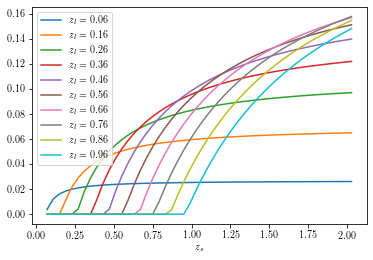

In [34]:

"""
# Check the Spectrum estimation on the line-of-sight direction
print(sparse3D.lensKernel.shape)
print(0.1/np.sum(sparse3D.lensKernel**2.,axis=0))
print(sparse3D.mu[:,1,24,24])
"""

In [48]:
configName  =   'process-equalNum10/config.ini'
parser      =   ConfigParser()
parser.read(configName)
parser.set('file','fieldn','3D')
parser.set('sparse','nframe','3')
parser.set('sparse','lbd','5.')
parser.set('sparse','lbd2','0')
parser.set('sparse','aprox_method','pathwise')
sparse3D_1    =   massmapSparsityTask(parser)
sparse3D_1.process()

Text(0.5, 0, '$z_s$')

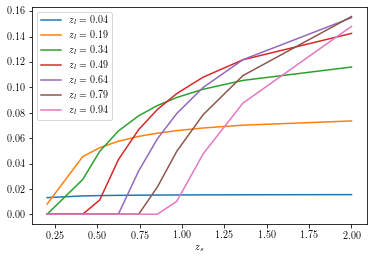

In [62]:
for il in range(sparse3D_1.nlp)[0::3]:
    ker=sparse3D_1.lensKernel[:,il]
    plt.plot(sparse3D_1.zsBin,ker,label=r'$z_l=%.2f$' %sparse3D_1.zlBin[il])
plt.legend(loc='upper left')
plt.xlabel(r'$z_s$')

### Pathwise Coordniate Descent Reconstruction
### FISTA Gradient Descent Reconstruction

In [53]:
fig1=ipv.figure(figtext='Pathwise')
vol1=ipv.quickvolshow(sparse3D_1.deltaR,fig1,level=[0.4,0.6,0.8],opacity=[0.1,0.4,0.7],extent=[[-24,24],[-24,24],[0.01,1.01]])
ipv.xlabel('ra (arcmin)')
ipv.ylabel('dec (arcmin)')
ipv.show()

#fig2=ipv.figure(figtext='FISTA')
#vol2=ipv.quickvolshow(sparse3D_2.deltaR,fig2,level=[0.4,0.6,0.8],opacity=[0.1,0.4,0.7],extent=[[-24,24],[-24,24],[0.01,1.01]]) 
#ipv.xlabel('ra (arcmin)')
#ipv.ylabel('dec (arcmin)')
#ipv.show()

### lambda as function of iteration

Text(0, 0.5, '$\\lambda$')

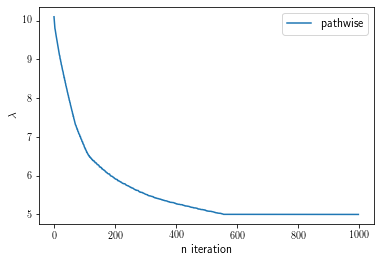

In [54]:
plt.plot(sparse3D_1.lbd_path[1:],label='pathwise')
#plt.plot(np.ones(50)*5.,label='fista')
plt.legend(fontsize=12)
plt.xlabel('n iteration',fontsize=12)
plt.ylabel(r'$\lambda$',fontsize=12)

In [26]:
sparse3D_1.deltaR.shape

(20, 64, 64)

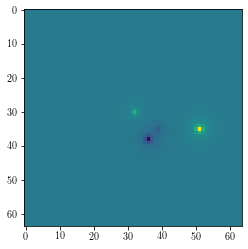

In [58]:
plt.imshow(sparse3D_1.deltaR[15])

In [61]:
sparse3D_1.deltaR[15].max()

1.8124536845786021